# Image Classification with Bag of Visual Words

In [83]:
! pip install datasets

## 1. Import Libraries

In [84]:
import numpy as np
from datasets import load_dataset, Dataset
import matplotlib.pyplot as plt
import pandas as pd
import random
from collections import Counter
from typing import List, Tuple

import cv2
from PIL import Image


from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 2. Load Data

In [85]:
# 1. Load the caltech-256 dataset
caltech256 = load_dataset("bitmind/caltech-256")

# 2. Explore the dataset structure
print("\nDataset structure:")
print(caltech256)
print(f"\nNumber of training examples: {len(caltech256)}")


Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'filename'],
        num_rows: 30607
    })
})

Number of training examples: 1


## 3. Data Exploration and Subsetting

In [86]:
# Extract labels from the 'filename' feature in the training dataset
def extract_label(example):
    example['class'] = example['filename'].split('.')[1].split('/')[0]
    return example

# Apply the function to the training, validation, and test datasets
caltech256 = caltech256.map(extract_label)

print("Labels extracted successfully!")
train_dataset = caltech256['train']

Labels extracted successfully!


Examine Data Structure

In [87]:
train_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=230x230>,
 'filename': '138.mattress/138_0117.jpg',
 'class': 'mattress'}

Examine and Filter classes

In [88]:
# Extract unique class names from the training dataset
uniqtrain_dataset = train_dataset.unique('class')
# Print the unique class names
class_names = list(uniqtrain_dataset)
print(f"\nUnique class names: {class_names}")

# Print the number of unique classes
print(f"Number of unique classes: {len(class_names)}")



Unique class names: ['mattress', 'hot-air-balloon', 'chess-board', 'buddha-101', 'butterfly', 'mailbox', 'gas-pump', 'ostrich', 'stained-glass', 'skateboard', 'homer-simpson', 'yo-yo', 'fireworks', 'snake', 'tombstone', 'baseball-glove', 'spider', 'chopsticks', 'bear', 'socks', 'cormorant', 'kangaroo-101', 'coffee-mug', 'theodolite', 'octopus', 'menorah-101', 'welding-mask', 'ak47', 'dumb-bell', 'laptop-101', 'soda-can', 'computer-keyboard', 'teddy-bear', 'centipede', 'rotary-phone', 'photocopier', 'vcr', 'beer-mug', 'school-bus', 'boxing-glove', 'lightbulb', 'unicorn', 'electric-guitar-101', 'computer-mouse', 'goose', 'sunflower-101', 'bowling-ball', 'yarmulke', 'hummingbird', 'desk-globe', 'sextant', 'cake', 'frisbee', 'cactus', 'teepee', 'microwave', 'grapes', 'tricycle', 'hot-dog', 'car-side-101', 'french-horn', 'umbrella-101', 'hamburger', 'watermelon', 'backpack', 'smokestack', 'tripod', 'skyscraper', 'billiards', 'tennis-racket', 'raccoon', 'sheet-music', 'doorknob', 'dice', 'g

In [89]:
selected_classes = ['airplanes-101','motorbikes-101','faces-easy-101','t-shirt','billiards','horse']
# Filter the training dataset to include only the selected classes
filtered_dataset = train_dataset.filter(lambda example: example['class'] in selected_classes)
print(f"Number of samples in the filtered dataset: {len(filtered_dataset)}")

Number of samples in the filtered dataset: 2939


Examine Number of Images per Label in data Subset

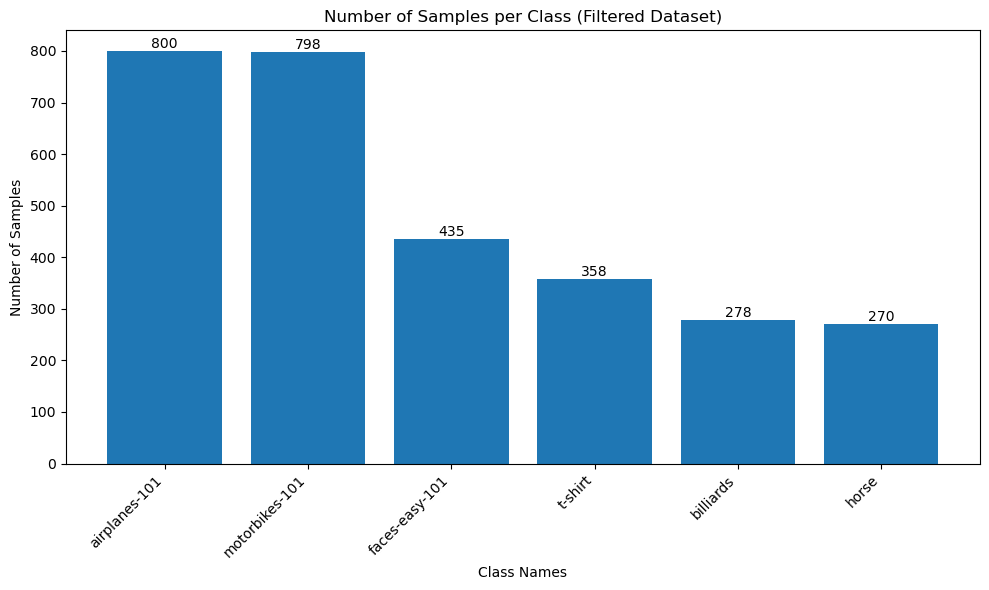

In [90]:
# Count the number of samples per class in the filtered training dataset
filtered_class_counts = Counter(example['class'] for example in filtered_dataset)

# Sort the filtered class counts by values in descending order
sorted_class_counts = dict(sorted(filtered_class_counts.items(), key=lambda item: item[1], reverse=True))

# Plot the bar chart with sorted labels
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_class_counts.keys(), sorted_class_counts.values())
plt.xlabel('Class Names')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class (Filtered Dataset)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

plt.tight_layout()
plt.show()


Access a sample image per label

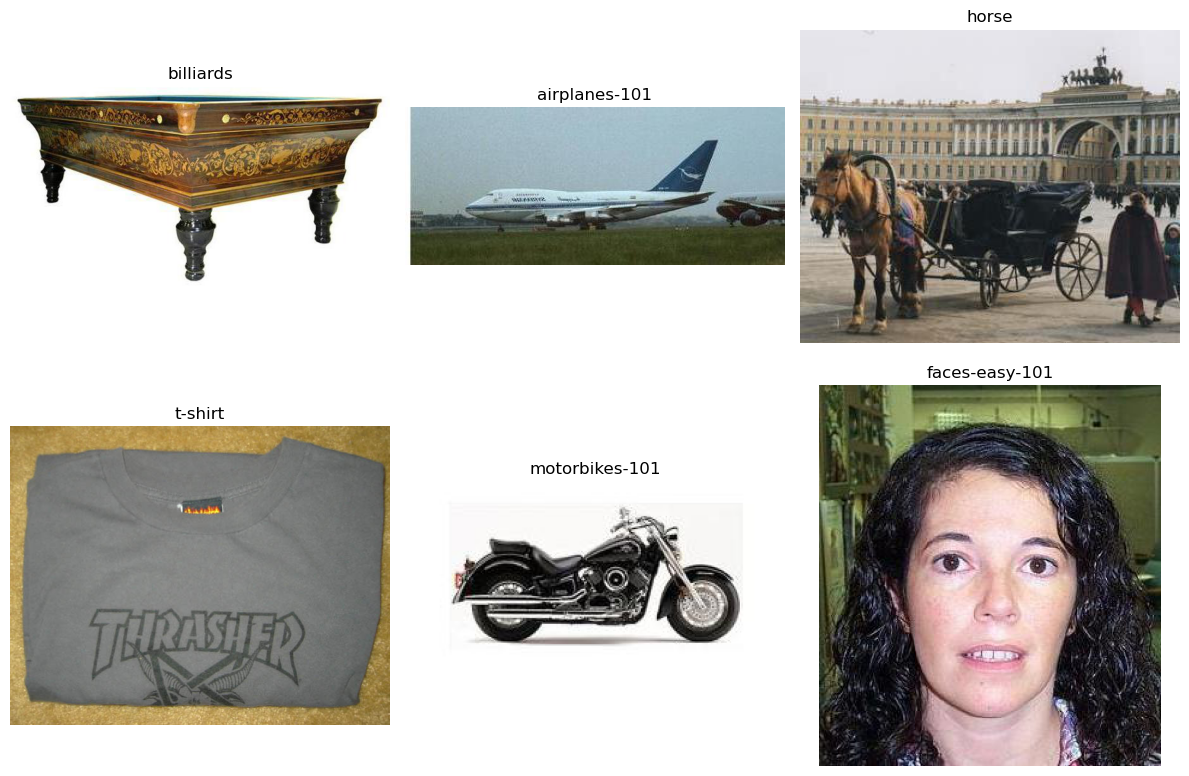

In [91]:
images_per_label = {}
# Extract images and labels from the filtered dataset
for example in filtered_dataset:
    label = example['class']
    image = example['image']
    if label not in images_per_label:
        images_per_label[label] = image
# Visualize images on a 2x3 grid
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
for i, (label, image) in enumerate(images_per_label.items()):
    if i >= 6:  # Limit to 6 images for a 2x3 grid
        break
    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.axis('off')  # Hide axes for better visualization
    plt.title(label)  # Display the label as the title

plt.tight_layout()
plt.show()

## 4. Data Pre-processing

### Data Augmentation for Class Balancing
The following Python function, `augment_dataset_to_balance`, performs data augmentation using image rotation to address class imbalance in a dataset. It aims to increase the number of samples in under-represented classes until each class reaches a specified `target_samples_per_class`.

In [92]:
# Function to perform data augmentation using rotation
def augment_dataset_to_balance(dataset, target_samples_per_class, rotation_angles=[60, 90, 180, 270]):
    augmented_dataset = []
    class_counts = Counter(example['class'] for example in dataset)
    
    for class_name, count in class_counts.items():
        # Filter examples of the current class
        class_examples = [example for example in dataset if example['class'] == class_name]
        augmented_dataset.extend(class_examples)
        
        # Perform augmentation to reach the target number of samples
        while len(class_examples) < target_samples_per_class:
            for example in class_examples:
                if len(class_examples) >= target_samples_per_class:
                    break
                # Rotate the image by a random angle
                rotated_image = example['image'].rotate(random.choice(rotation_angles))
                augmented_example = {
                    'image': rotated_image,
                    'filename': example['filename'],
                    'class': example['class']
                }
                class_examples.append(augmented_example)
                augmented_dataset.append(augmented_example)
    
    return augmented_dataset

In [93]:

# Perform data augmentation on the filtered dataset
target_samples_per_class = 1000
augmented_filtered_dataset = augment_dataset_to_balance(filtered_dataset, target_samples_per_class)

print(f"Number of samples after augmentation: {len(augmented_filtered_dataset)}")

Number of samples after augmentation: 6000


In [94]:
# Convert the augmented dataset (list of dictionaries) to a Dataset object
augmented_filtered_dataset = Dataset.from_dict({
    'image': [example['image'] for example in augmented_filtered_dataset],
    'filename': [example['filename'] for example in augmented_filtered_dataset],
    'class': [example['class'] for example in augmented_filtered_dataset]
})

We check again the number of samples per class 

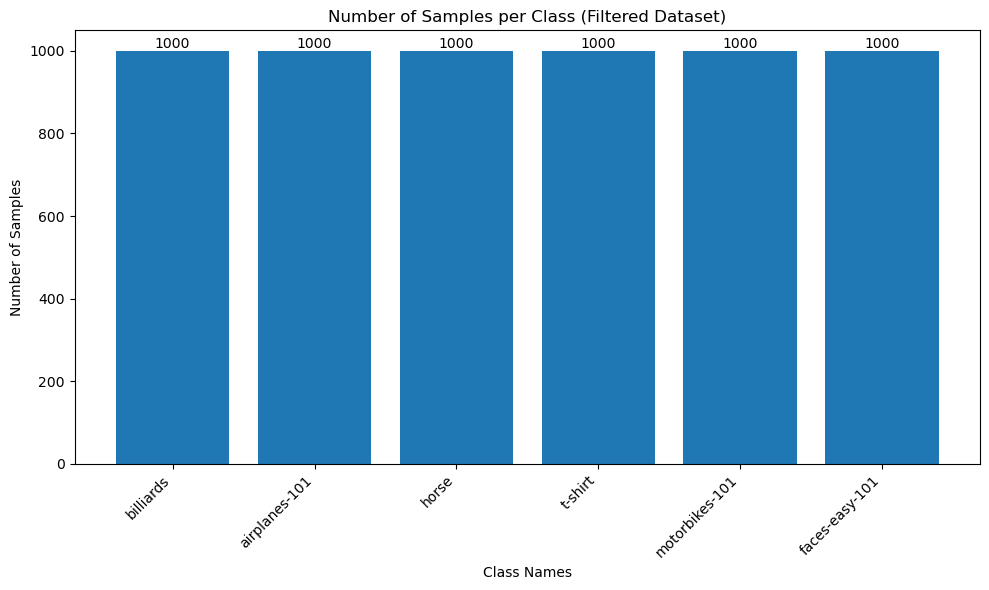

In [95]:
# Count the number of samples per class in the filtered training dataset
filtered_class_counts = Counter(example['class'] for example in augmented_filtered_dataset)

# Sort the filtered class counts by values in descending order
sorted_class_counts = dict(sorted(filtered_class_counts.items(), key=lambda item: item[1], reverse=True))

# Plot the bar chart with sorted labels
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_class_counts.keys(), sorted_class_counts.values())
plt.xlabel('Class Names')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class (Filtered Dataset)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

plt.tight_layout()
plt.show()


### Grayscale Image Conversion
The following code converts all images in the `augmented_filtered_dataset` to grayscale.
It uses the `.map()` function to apply the `.convert("L")` method
(from the PIL library) to each image entry in the dataset.

1100


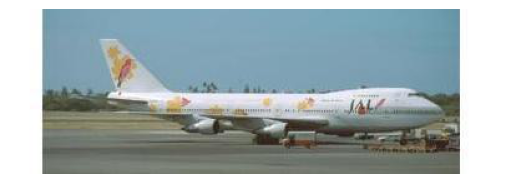

In [96]:
random.seed(1) #550
random_index = random.randint(0, len(augmented_filtered_dataset) - 1)
print(random_index)
random_image = augmented_filtered_dataset[random_index]['image']
plt.imshow(random_image) 
plt.axis('off')
plt.show()

In [97]:
# Transform images in the training dataset to grayscale
augmented_filtered_dataset = augmented_filtered_dataset.map(lambda example: {"image": example["image"].convert("L")})

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

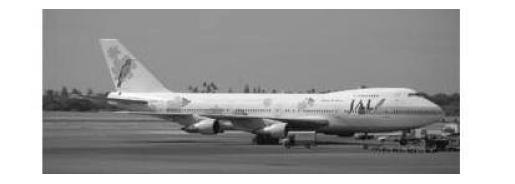

In [98]:
# Convert the PIL image to a NumPy array
random_image = augmented_filtered_dataset[random_index]['image']
image_array = np.array(random_image)

# Display the grayscale image
plt.imshow(image_array, cmap='gray')
plt.axis('off')
plt.show()


### Stratified Train/Test Split (80/20)
Extracts class labels and performs a stratified train-test split on the dataset.
Uses an 80% train / 20% test ratio, ensuring proportional class representation.
Creates `train_dataset` and `test_dataset` subsets and prints their sizes.

In [99]:
# Extract class labels for stratified splitting
labels = [example['class'] for example in augmented_filtered_dataset]

# Split the dataset into train and test sets (80% train, 20% test)
train_indices, test_indices = train_test_split(
    range(len(augmented_filtered_dataset)),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Create train and test datasets
train_dataset = augmented_filtered_dataset.select(train_indices)
test_dataset = augmented_filtered_dataset.select(test_indices)# Extract class labels for stratified splitting

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 4800
Test dataset size: 1200


In [100]:
# TEMP FOR DEV: Select 100 random samples from the training dataset

#random_indices = random.sample(range(len(train_dataset)), 1500)
#train_dataset = train_dataset.select(random_indices)

#print(f"Number of random samples selected: {len(train_dataset)}")

## 5. Bag Of Visual Words

### SIFT Feature Extraction Function
This section defines `extract_features` to get SIFT descriptors from an image.
Supports 'dense' (grid sampling) or 'keypoint' (detector) methods.
Limits features to `num_features` via random sampling or top response.

In [101]:
# Define the feature extraction function
def extract_features(method: str, image: np.ndarray, sift: cv2.SIFT, num_features: int, step_size: int = 8) -> Tuple[np.ndarray, np.ndarray]:
    """
    Extract features from an image using keypoint or dense sampling.

    Args:
        method: Feature extraction method ('dense' or 'keypoint').
        image: Input image (grayscale or BGR).
        sift: SIFT detector instance.
        num_features: Maximum number of features to extract.
        step_size: Step size for dense sampling (default: 8).

    Returns:
        keypoints: Detected keypoints.
        descriptors: Feature descriptors.
    """
    # Convert to grayscale if needed
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    if method == 'dense':
        # Dense sampling
        keypoints = []
        h, w = gray.shape
        for y in range(0, h, step_size):
            for x in range(0, w, step_size):
                kp = cv2.KeyPoint(x, y, step_size)
                keypoints.append(kp)

        # Extract descriptors
        keypoints, descriptors = sift.compute(gray, keypoints)
        # If we have too many features, randomly sample
        if descriptors is not None and len(descriptors) > num_features:
            idx = np.random.choice(len(descriptors), num_features, replace=False)
            descriptors = descriptors[idx]
            keypoints = [keypoints[i] for i in idx]


    if method == 'keypoint':
        # Keypoint detection
        keypoints, descriptors = sift.detectAndCompute(gray, None)

        # If we have too many features, sort by response and take top N
        if descriptors is not None and len(descriptors) > num_features:
            # Select the top `num_features` keypoints based on their response
            keypoints_desc = sorted(zip(keypoints, descriptors),
                                     key=lambda x: x[0].response,
                                     reverse=True)[:num_features]
            keypoints = [kd[0] for kd in keypoints_desc]
            descriptors = np.array([kd[1] for kd in keypoints_desc])
    
    return keypoints, descriptors

In [102]:
# Initialize the SIFT detector
sift = cv2.SIFT_create(nfeatures=0, contrastThreshold=0.01, edgeThreshold=20)

# Ensure the image is extracted from the dictionary and converted to a NumPy array
image_array = np.array(random_image)

Test on random sample using 'keypoint' detector

Keypoints: [< cv2.KeyPoint 0000027322FCFA20>, < cv2.KeyPoint 0000027322FCF180>, < cv2.KeyPoint 0000027322FCE6A0>, < cv2.KeyPoint 0000027322FCE730>, < cv2.KeyPoint 0000027322FCD0B0>, < cv2.KeyPoint 0000027322FCCF90>, < cv2.KeyPoint 000002732307B840>, < cv2.KeyPoint 0000027322FCDCB0>, < cv2.KeyPoint 0000027323079F50>, < cv2.KeyPoint 000002732307AEE0>, < cv2.KeyPoint 0000027322FCF510>, < cv2.KeyPoint 000002732307B1E0>, < cv2.KeyPoint 0000027322FCDD40>, < cv2.KeyPoint 0000027322FCC2D0>, < cv2.KeyPoint 0000027322FCFAE0>, < cv2.KeyPoint 0000027322FCEFD0>, < cv2.KeyPoint 0000027322FCE4C0>, < cv2.KeyPoint 0000027322FCD9E0>, < cv2.KeyPoint 0000027322FCF840>, < cv2.KeyPoint 0000027322FCF330>, < cv2.KeyPoint 0000027322FCFEA0>, < cv2.KeyPoint 0000027322FD7450>, < cv2.KeyPoint 0000027322FCE640>, < cv2.KeyPoint 0000027322FCE250>, < cv2.KeyPoint 0000027322FCDA40>, < cv2.KeyPoint 0000027322FCFF30>, < cv2.KeyPoint 000002732307AB50>, < cv2.KeyPoint 0000027322FCC5D0>, < cv2.KeyPoint 0000027322FCC720>, < 

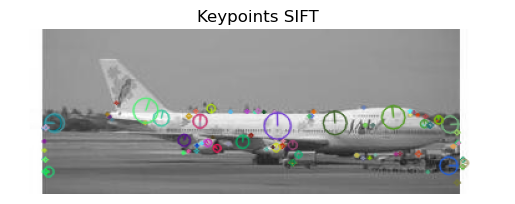

In [103]:
# Call the extract_features function with the correct image format
keypoints, descriptors = extract_features('keypoint', image_array, sift=sift, num_features=100, step_size=1)

# Print the results for verification
print("Keypoints:", keypoints), 
print("Descriptors shape:", descriptors.shape if descriptors is not None else "None")

# Visualize the keypoints on the image
image_with_keypoints = cv2.drawKeypoints(image_array, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the image with keypoints
plt.imshow(image_with_keypoints, cmap='gray')
plt.title("Keypoints SIFT")
plt.axis('off')
plt.show()

Test on random sample using 'dense' detector

Keypoints: [< cv2.KeyPoint 00000273B2CFAF40>, < cv2.KeyPoint 00000273B2CD99B0>, < cv2.KeyPoint 000002734D47AAC0>, < cv2.KeyPoint 00000273190613E0>, < cv2.KeyPoint 000002731EA0E220>, < cv2.KeyPoint 00000273DE98BF90>, < cv2.KeyPoint 0000027318FC2B80>, < cv2.KeyPoint 000002731E9FC8A0>, < cv2.KeyPoint 00000273B2CB1260>, < cv2.KeyPoint 000002734D45DAA0>, < cv2.KeyPoint 000002731EAB0AB0>, < cv2.KeyPoint 000002731902BCF0>, < cv2.KeyPoint 000002731EA0B8A0>, < cv2.KeyPoint 00000273DE98AAF0>, < cv2.KeyPoint 00000273190297A0>, < cv2.KeyPoint 000002731E9F1A10>, < cv2.KeyPoint 00000273B2CFD020>, < cv2.KeyPoint 00000273DE971710>, < cv2.KeyPoint 000002731EAA0060>, < cv2.KeyPoint 000002731E9D4990>, < cv2.KeyPoint 00000273DE968F90>, < cv2.KeyPoint 0000027318F9E820>, < cv2.KeyPoint 00000273DEA06040>, < cv2.KeyPoint 00000273B2C38090>, < cv2.KeyPoint 000002731EA7CE70>, < cv2.KeyPoint 000002731E9C9D70>, < cv2.KeyPoint 000002731EA6F330>, < cv2.KeyPoint 000002734D3E72A0>, < cv2.KeyPoint 00000273DE980ED0>, < 

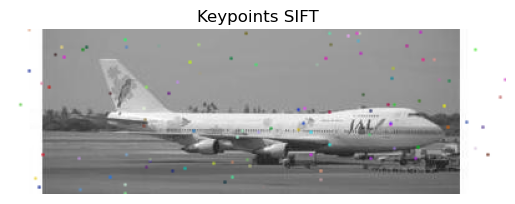

In [104]:
# Call the extract_features function with the correct image format
keypoints, descriptors = extract_features('dense', image_array, sift=sift, num_features=100, step_size=1)

# Print the results for verification
print("Keypoints:", keypoints), 
print("Descriptors shape:", descriptors.shape if descriptors is not None else "None")

# Visualize the keypoints on the image
image_with_keypoints = cv2.drawKeypoints(image_array, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the image with keypoints
plt.imshow(image_with_keypoints, cmap='gray')
plt.title("Keypoints SIFT")
plt.axis('off')
plt.show()

### Build Visual Vocabulary (Bag-of-Words)
Creates a visual vocabulary by clustering SIFT features from images.
Extracts 'keypoint' SIFT descriptors from each image in `image_list`.
Applies K-Means clustering (`num_clusters`) to all descriptors.
Returns the K-Means model and the cluster centers (visual words).

In [105]:
def build_vocabulary(image_list: List[np.ndarray], num_clusters: int) -> np.ndarray:
    """
    Build visual vocabulary from a list of images.

    Args:
        image_list: List of input images.
        num_clusters: Number of clusters for k-means.

    Returns:
        visual_words: Cluster centers representing the visual vocabulary.
    """
    all_descriptors = []

    # Extract features from all images
    for img in image_list:
        _, desc = extract_features('keypoint', img, sift, num_features=100)
        if desc is not None:
            all_descriptors.extend(desc)

    if not all_descriptors:
        raise ValueError("No descriptors extracted from images")

    # Convert to numpy array
    all_descriptors = np.array(all_descriptors)

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(all_descriptors)
    visual_words = kmeans.cluster_centers_

    return kmeans, visual_words

In [106]:
train_dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=409x187>,
 'filename': '251.airplanes-101/251_0791.jpg',
 'class': 'airplanes-101'}

In [107]:
# Extract all images from the training dataset
all_train_images = [np.array(example['image']) for example in train_dataset]

# Build the vocabulary using all training images
num_clusters = 100  # You can adjust this value as needed

kmeans, visual_words = build_vocabulary(image_list=all_train_images, num_clusters=5)
print("Vocabulary built successfully!")

Vocabulary built successfully!


### Compute Bag-of-Visual-Words Histograms
Defines `compute_histograms` to represent images as BoVW histograms.
Extracts patches, computes SIFT, assigns visual words via `kmeans`, and builds histograms.
Calculates these histograms for the `train_dataset`.

In [108]:
def compute_histograms(dataset, kmeans, sift, patch_size=(8, 8), max_patches=100):
    histograms = []
    for example in dataset:
        image = np.array(example['image'])
        patches = extract_patches_2d(image, patch_size, max_patches=max_patches)
        
        # Extract SIFT descriptors for each patch
        descriptors_list = []
        for patch in patches:
            keypoints, descriptors = sift.detectAndCompute(patch, None)
            if descriptors is not None:
                descriptors_list.append(descriptors)
        
        # Flatten the list of descriptors
        if descriptors_list:
            all_descriptors = np.vstack(descriptors_list)
        else:
            all_descriptors = np.empty((0, kmeans.n_clusters))
        
        # Predict visual words for the descriptors
        if all_descriptors.shape[0] > 0:
            labels = kmeans.predict(all_descriptors)
            histogram, _ = np.histogram(labels, bins=np.arange(kmeans.n_clusters + 1))
        else:
            histogram = np.zeros(kmeans.n_clusters)
        
        histograms.append(histogram)
    return np.array(histograms)

# Compute histograms for training images
train_histograms = compute_histograms(train_dataset, kmeans, sift)

print("Bag of Visual Words model deployed successfully!")

Bag of Visual Words model deployed successfully!


Now we visualize the histogram for one of the samples

In [109]:
random_index

1100

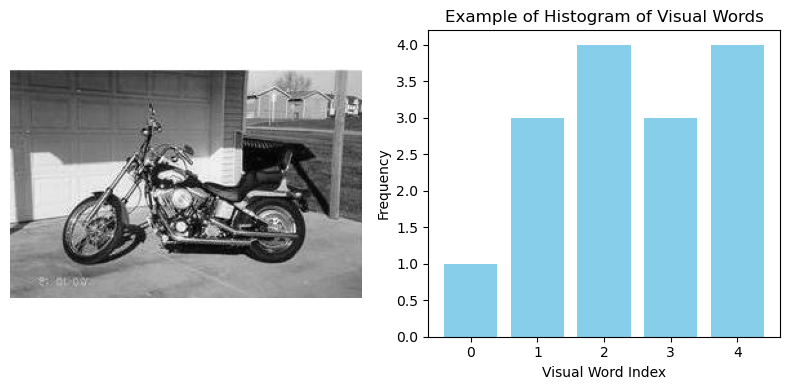

In [110]:
random_index = 250

plt.figure(figsize=(8, 4))

# Display the image on the left
plt.subplot(1, 2, 1)
if random_index < len(train_dataset):
	plt.imshow(np.array(train_dataset[random_index]['image']), cmap='gray')
else:
	print("Random index is out of bounds for the training dataset.")
plt.axis('off')  # Hide axes for the image

# Display the histogram on the right
plt.subplot(1, 2, 2)
plt.bar(range(len(train_histograms[random_index])), train_histograms[random_index], color='skyblue')
plt.title("Example of Histogram of Visual Words")
plt.xlabel("Visual Word Index")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

### Naive Bayes Classifier Training and Evaluation
Trains a Gaussian Naive Bayes classifier using the training histograms and labels.
Computes histograms for the test set and predicts test labels (using `svm_classifier`).
Calculates and prints the classification error rates on both training and test sets.

In [28]:
# Extract labels from the training dataset
train_labels = [example['class'] for example in train_dataset]

# Initialize and train the Naive Bayes classifier
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(train_histograms, train_labels)

# Evaluate the classifier on the training data
train_predictions = naive_bayes_classifier.predict(train_histograms)
train_error = 1 - accuracy_score(train_labels, train_predictions)

# Evaluate the classifier on the test data
test_labels = [example['class'] for example in test_dataset]
test_histograms = compute_histograms(test_dataset, kmeans, sift)
test_predictions = naive_bayes_classifier.predict(test_histograms)
test_error = 1- accuracy_score(test_labels, test_predictions)


print(f"Training error: {train_error:.2f}")
print(f"Test error: {test_error:.2f}")

Training error: 0.72
Test error: 0.72


Compute the confusion matrix

<Figure size 1000x800 with 0 Axes>

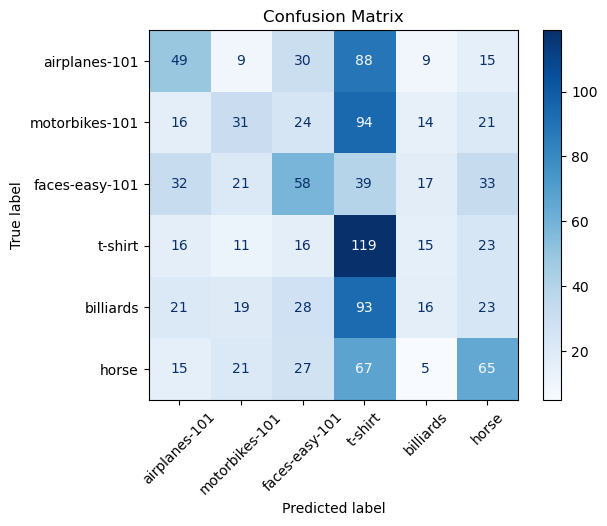

In [29]:
cm = confusion_matrix(test_labels, test_predictions, labels=selected_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=selected_classes)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

## 6. Hyperparamether Tunning

### Impact of Vocabulary Size (k) on Naive Bayes Error
This section evaluates the effect of different vocabulary sizes (`k`).
It iterates through `vocabulary_sizes`, building BoVW models, training Gaussian Naive Bayes,
and calculating the test error for each `k` to observe performance trends.

In [ ]:
# Define a range of vocabulary sizes to test
vocabulary_sizes = [5, 10, 20, 100, 200, 400, 1000, 1500, 2000]

# Initialize a list to store the errors for each vocabulary size
errors = []

# Loop through each vocabulary size
for k in vocabulary_sizes:
    # Build the vocabulary using the current vocabulary size
    kmeans, visual_words = build_vocabulary(image_list=all_train_images, num_clusters=k)
    
    # Compute histograms for training and test datasets
    train_histograms = compute_histograms(train_dataset, kmeans, sift)
    test_histograms = compute_histograms(test_dataset, kmeans, sift)
    
    # Train the Naive Bayes classifier
    naive_bayes_classifier = GaussianNB()
    naive_bayes_classifier.fit(train_histograms, train_labels)
    
    # Predict labels for the test dataset
    test_predictions = naive_bayes_classifier.predict(test_histograms)
    
    # Calculate the test error
    test_error = 1 - accuracy_score(test_labels, test_predictions)
    errors.append(test_error)



Plot the error for each vocabulary size

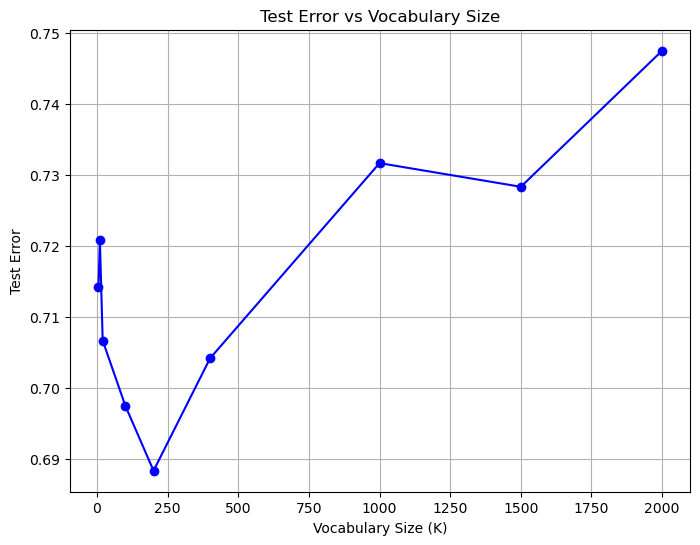

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(vocabulary_sizes, errors, marker='o', linestyle='-', color='b')
plt.xlabel('Vocabulary Size (K)')
plt.ylabel('Test Error')
plt.title('Test Error vs Vocabulary Size')
plt.grid(True)
plt.show()

### Classifier Comparison (Naive Bayes, KNN) with optimal K
Now, we fix the vocabulary size to 200 and perform a classifier comparison. 
We train and evaluate Gaussian Naive Bayes and K-Nearest Neighbors classifiers.
Their test errors are calculated using the test set labels.

In [81]:
from sklearn.metrics import classification_report

vocabulary_size = 200  
kmeans, visual_words = build_vocabulary(image_list=all_train_images, num_clusters=vocabulary_size)

# Compute histograms for training and test datasets
train_histograms = compute_histograms(train_dataset, kmeans, sift)
test_histograms = compute_histograms(test_dataset, kmeans, sift)

# Initialize classifiers
naive_bayes_classifier = GaussianNB()
svm_classifier = SVC(kernel='linear', random_state=27)
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

# Train and evaluate Naive Bayes
naive_bayes_classifier.fit(train_histograms, train_labels)
naive_bayes_predictions = naive_bayes_classifier.predict(test_histograms)
naive_bayes_error = 1 - accuracy_score(test_labels, naive_bayes_predictions)

# Train and evaluate SVM
svm_classifier.fit(train_histograms, train_labels)
svm_predictions = svm_classifier.predict(test_histograms)
svm_error = 1 - accuracy_score(test_labels, svm_predictions)

# Train and evaluate KNN
knn_classifier.fit(train_histograms, train_labels)
knn_predictions = knn_classifier.predict(test_histograms)
knn_error = 1 - accuracy_score(test_labels, knn_predictions)

# Generate classification reports
naive_bayes_report = classification_report(test_labels, naive_bayes_predictions, target_names=selected_classes, output_dict=True)
svm_report = classification_report(test_labels, svm_predictions, target_names=selected_classes, output_dict=True)
knn_report = classification_report(test_labels, knn_predictions, target_names=selected_classes, output_dict=True)

# Display results in a table
results = pd.DataFrame({
    "Classifier": ["Naive Bayes", "SVM", "KNN"],
    "Test Error": [naive_bayes_error, svm_error, knn_error],
    "Accuracy": [naive_bayes_report['accuracy'], svm_report['accuracy'], knn_report['accuracy']],
    "Precision": [naive_bayes_report['weighted avg']['precision'], svm_report['weighted avg']['precision'], knn_report['weighted avg']['precision']],
    "Recall": [naive_bayes_report['weighted avg']['recall'], svm_report['weighted avg']['recall'], knn_report['weighted avg']['recall']],
    "F1-Score": [naive_bayes_report['weighted avg']['f1-score'], svm_report['weighted avg']['f1-score'], knn_report['weighted avg']['f1-score']]
})

results

,Classifier,Test Error,Accuracy,Precision,Recall,F1-Score
0,Naive Bayes,0.753333,0.246667,0.270109,0.246667,0.218239
1,SVM,0.678333,0.321667,0.323725,0.321667,0.317557
2,KNN,0.793333,0.206667,0.234361,0.206667,0.177114


## 7. Final BoVW Model Training and SVM Evaluation (k=200)
This section trains the final Bag-of-Visual-Words model with vocabulary size 200.
It computes histograms, trains an SVM classifier with a linear kernel,
evaluates its error, and generates a detailed classification report.

In [111]:
train_labels = [example['class'] for example in train_dataset]
vocabulary_size = 200  
kmeans, visual_words = build_vocabulary(image_list=all_train_images, num_clusters=vocabulary_size)
train_histograms = compute_histograms(train_dataset, kmeans, sift)
test_histograms = compute_histograms(test_dataset, kmeans, sift)
svm_classifier = SVC(kernel='linear', random_state=27)
svm_classifier.fit(train_histograms, train_labels)
svm_predictions = svm_classifier.predict(test_histograms)
svm_error = 1 - accuracy_score(test_labels, svm_predictions)
svm_report = classification_report(test_labels, svm_predictions, target_names=selected_classes, output_dict=True)

<Figure size 1000x800 with 0 Axes>

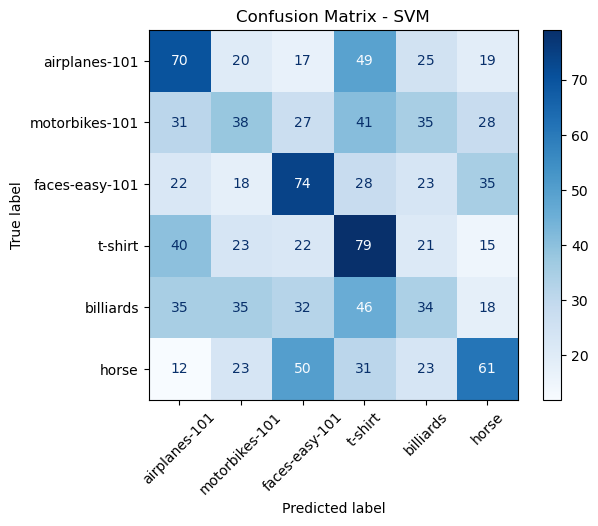

In [116]:
# Compute the confusion matrix for SVM
cm_svm = confusion_matrix(test_labels, svm_predictions, labels=selected_classes)

# Plot the confusion matrix
disp_naive_bayes = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=selected_classes)
plt.figure(figsize=(10, 8))
disp_naive_bayes.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - SVM")
plt.show()

In [117]:
results[results['Classifier'] == 'SVM']

,Classifier,Test Error,Accuracy,Precision,Recall,F1-Score
1,SVM,0.678333,0.321667,0.323725,0.321667,0.317557
